In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  #use 2080Ti


In [35]:
base_dir = 'dataset-diabnext'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [36]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 30,
        width_shift_range = 0.3,
        height_shift_range = 0.3,
        shear_range = 0.3,
        zoom_range = 0.4,
        channel_shift_range = 0.2,
        fill_mode = 'nearest',
        horizontal_flip = True,
        vertical_flip = False,    
)
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 30,
        width_shift_range = 0.3,
        height_shift_range = 0.3,
        shear_range = 0.3,
        zoom_range = 0.4,
        channel_shift_range = 0.2,
        fill_mode = 'nearest',
        horizontal_flip = True,
        vertical_flip = False,  
)


train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=10,  
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 1140 images belonging to 10 classes.
Found 370 images belonging to 10 classes.
Found 370 images belonging to 10 classes.


In [37]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras.layers.normalization import BatchNormalization


cnn_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

cnn_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [38]:
'''
cnn_base.trainable = True

set_trainable = False
for layer in cnn_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
'''
cnn_base.trainable = True

for layer in cnn_base.layers:
    #layer.trainable = False
    #if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
    if layer.name in ('block1_conv1'):
    #if layer.name in ('block5_conv1', 'block5_conv2'):
        layer.trainable = True
    else:
        layer.trainable = False
     

In [39]:
classify = models.Sequential()
classify.add(BatchNormalization())
classify.add(layers.Flatten())
classify.add(layers.Dense(512, activation='relu'))
classify.add(layers.Dropout(0.5))
classify.add(layers.Dense(10, activation='sigmoid'))

In [40]:
model = models.Sequential()
model.add(cnn_base)
model.add(classify)
cnn_base.summary()
classify.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [41]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=10)

Epoch 1/50
21/50 [===========>..................] - ETA: 7s - loss: 2.4669 - acc: 0.1286

/home/chtseng/envs/AI/lib/python3.6/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


50/50 [==============================] - 13s 255ms/step - loss: 2.4864 - acc: 0.1240 - val_loss: 2.3680 - val_acc: 0.1400
Epoch 2/50
50/50 [==============================] - 10s 195ms/step - loss: 2.3510 - acc: 0.1440 - val_loss: 2.1853 - val_acc: 0.2200
Epoch 3/50
 9/50 [====>.........................] - ETA: 8s - loss: 2.4754 - acc: 0.1000

/home/chtseng/envs/AI/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


50/50 [==============================] - 11s 227ms/step - loss: 2.3092 - acc: 0.1640 - val_loss: 2.1484 - val_acc: 0.2600
Epoch 4/50
50/50 [==============================] - 11s 219ms/step - loss: 2.1907 - acc: 0.2080 - val_loss: 2.1069 - val_acc: 0.2300
Epoch 5/50
50/50 [==============================] - 11s 210ms/step - loss: 2.1954 - acc: 0.2100 - val_loss: 2.0636 - val_acc: 0.3100
Epoch 6/50
50/50 [==============================] - 12s 232ms/step - loss: 2.1241 - acc: 0.2520 - val_loss: 2.0134 - val_acc: 0.3300
Epoch 7/50
50/50 [==============================] - 11s 217ms/step - loss: 2.0825 - acc: 0.3020 - val_loss: 1.9653 - val_acc: 0.3400
Epoch 8/50
50/50 [==============================] - 12s 232ms/step - loss: 2.0741 - acc: 0.2880 - val_loss: 1.9347 - val_acc: 0.3700
Epoch 9/50
50/50 [==============================] - 11s 219ms/step - loss: 2.1187 - acc: 0.2720 - val_loss: 1.8617 - val_acc: 0.4700
Epoch 10/50
50/50 [==============================] - 12s 236ms/step - loss: 1.97

In [42]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=15)
print("test_acc:", test_acc)

test_acc: 0.6200000047683716


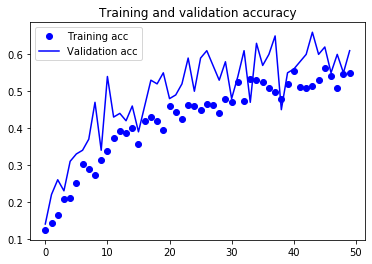

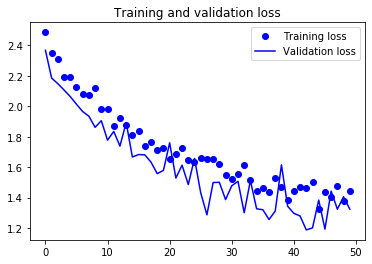

In [43]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
from numba import cuda
cuda.select_device(0)
cuda.close()